# Fit binned-floor acquisition probability model in 2022-11

This is the acquisition and probability model calculated in 2022-08.  

Copied from the 2022-02 notebook, modified slightly and re-run.

**The output model was NOT PROMOTED to allow development of a better model
and because the current flight model is conservative**.

## Notebook changelog

### Changes from 2022-02 Fit binned-floor acquisition probability model

- NONE

### Changes from 2021-06 Fit binned-floor acquisition probability model

- Split acq sampling plots into separate flight and ASVT plots.
- Do not show halfwidth=180 acq sampling plots (only ASVT at this point).
- Added marker to flight data in P_fail flight model vs. flight data plots.

### Changes from 2020-11 Fit binned-floor acquisition probability model

- Remove filtering known bad obsids since there are none in the fit data.
- Only use ASVT data with MAXMAG clipped.
- Refactor a couple of cells into functions for re-use.
- Add a plot comparing flight data since July 1, 2019 when MAXMAG clipping
  was used in commanding for flight products.

### Changes from 2020-02 Fit binned-floor acquisition probability model

- Added diagnostic plots at the end showing sampling of temperatures and time in order
  to evaluate data coverage for the updated model fit.
- Fixed a matplotlib 3.3 incompatibility in ``plt.hist``.

## Model description

### Key features of the model for color != 1.5 stars (with good mag estimates)

- Incorporates ASVT data for `t_ccd >= -10 C` in order to provide reasonable estimates
  of probability in regimes with little or no flight data.
- Fits a quadradatic model for `p_fail` (probit) as a 
  function of `t_ccd` in a series of magnitude bins.  The mag bins are driven by magnitudes 
  of ASVT simulated data.
- Model now includes a `floor` parameter that sets a hard lower limit on `p_fail`.
  This is seen in data and represents other factors that cause acquisition failure
  independent of `t_ccd`.  In other words, even for an arbitrarily cold CCD there will
  still be a small fraction of acquisition failures.  For flight data this can include
  spoilers or an ionizing radiation flag.
- As in past models, the `p_fail` model is adjusted by a `box_delta` term which applies
  a search-box dependent offset in probit space.  The `box_delta` term is defined to
  have a value of 0.0 for box `halfwidth = 120`.
- The global model (for arbitrary `mag`) is computed by linearly interpolating the
  binned quadratic coefficients as a function of `mag`.  The previous flight model
  (`spline`) did a global `mag` - `t_ccd` fit using a 5-element spline in the
  `mag` direction.
  
### Key features of the model for color == 1.5 stars (with poor mag estimates)

- Post AGASC 1.7, there is inadequate data to independently perform the binned
  fitting.
- Instead assume a magnitude error distribution which is informed by examining
  the observed distribution of `dmag = mag_obs - mag_aca` (observed - catalog).  This
  turns out to be well-represented by an `exp(-abs(dmag) / dmag_scale)`
  distribution.  This contrasts with a gaussian that scales as `exp(dmag^2)`.
- Use the assumed mag error distribution and sample the `color != 1.5` star
  probabilities accordingly and compute the weighted mean failure probability.
- Flight data show a steeper falloff for `dmag > 0` (stars observed to be fainter
  than expected) than for `dmag < 0`.  As noted by JC this likely includes a
  survival effect that stars which are actually much fainter don't get acquired
  and do not get into the sample.  Indeed using the observed distribution gives
  a poor fit to flight data, so `dmag_scale` for `dmag > 0` was arbitrarily
  increased from 2.8 to 4.0 in order to better fit flight data.
  
### Model details

- In order to get a good match to flight data for faint stars near -11 C, it
  was necessary to apply an ad-hoc correction to ASVT data for `mag > 10.1`.
  The correction effectively made the model assume *smaller* search box sizes,
  so for the canonical 120 arcsec box the model `p_fail` is slightly increased
  relative to the raw failure rate from ASVT.
- The `mag = 8.0` data from ASVT show a dependence on search-box size that is
  flipped from usual.  There are more failures for smaller search boxes,
  though we are dealing with small number statistics (up to 3 fails per bin).
  This caused problems in the fitting, so for this bin the `box_delta` term
  was simplied zeroed out and a good fit was obtained in the automatic fit
  process.  Since `p_fail` is quite low in all cases this has little practical
  impact either way.
- Fitting now uses binomial statistics to compute the fit statistic during
  model parameter optimization.  Previously it was using a poisson statistic
  which is similar except near 1.0.  The poisson statistic is built in to
  Sherpa and was easier, but the new binomial statistic is formally correct
  and behaves better for probabilities near 1.0.

### Paradigm shift for production model implementation

- This model is complicated, and the `color = 1.5` star case is computationally
  intensive.
- Instead of transfering the analytic algorithm and fit values into 
  `chandra_aca.star_probs` for production use, take a new approach of generating
  a 3-d grid of `p_fail` (in probit space) as a function of `mag`, `t_ccd`,
  and `halfwidth`.  Do this for `color != 1.5` and `color = 1.5`.
- The ranges are `5.0 <= mag <= 12.0`, `-16 <= t_ccd <= -1`, and
  `60 <= halfwidth <= 180`.  Values outside that range are clipped.
- This separates the model generation from the production model calculation.
- Gridded 3-d linear interpolation is used in `chandra_aca` and is quite fast.
- The gridded value files are about 150 kb, and make it easy to generate
  new models without changing code in `chandra_aca` (except for a hard-coded
  value for the default model).

In [1]:
import sys
import os
from itertools import count
from pathlib import Path

# Include utils.py for asvt_utils
sys.path.insert(0, str(Path(os.environ['HOME'], 'git', 'skanb', 'pea-test-set')))
import utils as asvt_utils

import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack
from astropy.time import Time
import tables
from scipy import stats
from scipy.interpolate import CubicSpline
from Chandra.Time import DateTime
from astropy.table import Table
from chandra_aca.star_probs import (get_box_delta, broadcast_arrays, 
                                    acq_success_prob, grid_model_acq_prob)
from chandra_aca import star_probs

%matplotlib inline

In [2]:
MODEL_DATE = '2022-11'
MODEL_NAME = f'grid-floor-{MODEL_DATE}'

In [3]:
np.random.seed(0)

In [4]:
SKA = Path(os.environ['SKA'])

## Get acq stats data and clean

In [5]:
# Make a map of AGASC_ID to AGACS 1.7 MAG_ACA.  The acq_stats.h5 file has whatever MAG_ACA
# was in place at the time of planning the loads.
# Define new term `red_mag_err` which is used here in place of the 
# traditional COLOR1 == 1.5 test.
with tables.open_file(str(SKA / 'data' / 'agasc' / 'miniagasc_1p7.h5'), 'r') as h5:
    agasc_mag_aca = h5.root.data.col('MAG_ACA')
    agasc_id = h5.root.data.col('AGASC_ID')
    has_color3 = h5.root.data.col('RSV3') != 0  # 
    red_star = np.isclose(h5.root.data.col('COLOR1'), 1.5)
    mag_aca_err = h5.root.data.col('MAG_ACA_ERR') / 100
    red_mag_err = red_star & ~has_color3  # MAG_ACA, MAG_ACA_ERR is potentially inaccurate

In [6]:
agasc1p7_idx = {id: idx for id, idx in zip(agasc_id, count())}
agasc1p7 = Table([agasc_mag_aca, mag_aca_err, red_mag_err], 
                 names=['mag_aca', 'mag_aca_err', 'red_mag_err'], copy=False)

In [7]:
acq_file = str(SKA / 'data' / 'acq_stats' / 'acq_stats.h5')
with tables.open_file(str(acq_file), 'r') as h5:
    cols = h5.root.data.cols
    names = {'tstart': 'guide_tstart',
             'obsid': 'obsid',
             'obc_id': 'acqid',
             'halfwidth': 'halfw',
             'warm_pix': 'n100_warm_frac',
             'mag_aca': 'mag_aca',
             'mag_obs': 'mean_trak_mag',
             'known_bad': 'known_bad',
             'color': 'color1',
            'img_func': 'img_func', 
            'ion_rad': 'ion_rad',
            'sat_pix': 'sat_pix',
             'agasc_id': 'agasc_id',
             't_ccd': 'ccd_temp',
            'slot': 'slot'}
    acqs = Table([getattr(cols, h5_name)[:] for h5_name in names.values()],
                 names=list(names.keys()))    

In [8]:
year_q0 = 1999.0 + 31. / 365.25  # Jan 31 approximately
acqs['year'] = Time(acqs['tstart'], format='cxcsec').decimalyear.astype('f4')
acqs['quarter'] = (np.trunc((acqs['year'] - year_q0) * 4)).astype('f4')

In [9]:
# Create 'fail' column, rewriting history as if the OBC always
# ignore the MS flag in ID'ing acq stars.
#
# CHECK: is ion_rad being ignored on-board?
# Answer: Not as of 2022-08
#
obc_id = acqs['obc_id']
obc_id_no_ms = (acqs['img_func'] == 'star') & ~acqs['sat_pix'] & ~acqs['ion_rad']
acqs['fail'] = np.where(obc_id | obc_id_no_ms, 0.0, 1.0)

# Re-map acq_stats database magnitudes for AGASC 1.7
acqs['mag_aca'] = [agasc1p7['mag_aca'][agasc1p7_idx[agasc_id]] for agasc_id in acqs['agasc_id']]
acqs['red_mag_err'] = [agasc1p7['red_mag_err'][agasc1p7_idx[agasc_id]] for agasc_id in acqs['agasc_id']]
acqs['mag_aca_err'] = [agasc1p7['mag_aca_err'][agasc1p7_idx[agasc_id]] for agasc_id in acqs['agasc_id']]

# Add a flag to distinguish flight from ASVT data
acqs['asvt'] = False

In [10]:
# Filter for year and mag
#
year_max = Time(f'{MODEL_DATE}-01').decimalyear
year_min = year_max - 4.5
acq_ok = ((acqs['year'] > year_min) & (acqs['year'] < year_max) & 
          (acqs['mag_aca'] > 7.0) & (acqs['mag_aca'] < 11) &
          (~np.isclose(acqs['color'], 0.7)))

## Get ASVT data and make it look more like acq stats data

In [11]:
peas = Table.read('pea_analysis_2019_172_AcqProbModel_calibration_test_results_w_11p2_cap.csv',
                  format='ascii.csv')
peas = asvt_utils.flatten_pea_test_data(peas)
peas = peas[peas['ccd_temp'] > -10.5]

In [12]:
# Version of ASVT PEA data that is more flight-like
fpeas = Table([peas['star_mag'], peas['ccd_temp'], peas['search_box_hw']],
              names=['mag_aca', 't_ccd', 'halfwidth'])
fpeas['year'] = np.random.uniform(2019.0, 2019.5, size=len(peas))
fpeas['color'] = 1.0
fpeas['quarter'] = (np.trunc((fpeas['year'] - year_q0) * 4)).astype('f4')
fpeas['fail'] = 1.0 - peas['search_success']
fpeas['asvt'] = True
fpeas['red_mag_err'] = False
fpeas['mag_obs'] = 0.0

## Combine flight acqs and ASVT data

In [13]:
data_all = vstack([acqs[acq_ok]['year', 'fail', 'mag_aca', 't_ccd', 'halfwidth', 'quarter', 
                                'color', 'asvt', 'red_mag_err', 'mag_obs'], 
                   fpeas])
data_all.sort('year')

## Compute box probit delta term based on box size

In [14]:
# Adjust probability (in probit space) for box size. 
data_all['box_delta'] = get_box_delta(data_all['halfwidth'])

# Put in an ad-hoc penalty on ASVT data that introduces up to a -0.3 shift
# on probit probability.  It goes from 0.0 for mag < 10.1 up to 0.3 at mag=10.4.
ok = data_all['asvt']
box_delta_tweak = (data_all['mag_aca'][ok] - 10.1).clip(0, 0.3)
data_all['box_delta'][ok] -= box_delta_tweak

# Ad-hoc tweak: the mag=8.0 data show more failures at smaller
# box sizes.  This confounds the fitting.  For this case only just
# set the box deltas to zero and this makes the fit work.
ok = data_all['asvt'] & (data_all['mag_aca'] == 8)
data_all['box_delta'][ok] = 0.0

In [15]:
data_all = data_all.group_by('quarter')
data_all0 = data_all.copy()  # For later augmentation with simulated red_mag_err stars
data_mean = data_all.groups.aggregate(np.mean)

## Model definition

In [16]:
def t_ccd_normed(t_ccd):
    return (t_ccd + 8.0) / 8.0

def p_fail(pars, 
           t_ccd, tc2=None,
           box_delta=0, rescale=True, probit=False):
    """
    Acquisition probability model

    :param pars: p0, p1, p2 (quadratic in t_ccd) and floor (min p_fail)
    :param t_ccd: t_ccd (degC) or scaled t_ccd if rescale is False.
    :param tc2: (scaled t_ccd) ** 2, this is just for faster fitting
    :param box_delta: delta p_fail for search box size
    :param rescale: rescale t_ccd to about -1 to 1 (makes P0, P1, P2 better-behaved)
    :param probit: return probability as probit instead of 0 to 1.
    """
    p0, p1, p2, floor = pars

    tc = t_ccd_normed(t_ccd) if rescale else t_ccd
    
    if tc2 is None:
        tc2 = tc ** 2
    
    # Make sure box_delta has right dimensions
    tc, box_delta = np.broadcast_arrays(tc, box_delta)

    # Compute the model.  Also clip at +10 to avoid values that are
    # exactly 1.0 at 64-bit precision.
    probit_p_fail = (p0 + p1 * tc + p2 * tc2 + box_delta).clip(floor, 10)

    # Possibly transform from probit to linear probability
    out = probit_p_fail if probit else stats.norm.cdf(probit_p_fail)
    return out

def p_acq_fail(data=None):
    """
    Sherpa fit function wrapper to ensure proper use of data in fitting.
    """
    if data is None:
        data = data_all
        
    tc = t_ccd_normed(data['t_ccd'])
    tc2 = tc ** 2
    box_delta = data['box_delta']
    
    def sherpa_func(pars, x=None):
        return p_fail(pars, tc, tc2, box_delta, rescale=False)

    return sherpa_func

## Model fitting functions

In [17]:
def calc_binom_stat(data, model, staterror=None, syserror=None, weight=None, bkg=None):
    """
    Calculate log-likelihood for a binomial probability distribution
    for a single trial at each point.
    
    Defining p = model, then probability of seeing data == 1 is p and
    probability of seeing data == 0 is (1 - p).  Note here that ``data``
    is strictly either 0.0 or 1.0, and np.where interprets those float
    values as False or True respectively.
    """
    fit_stat = -np.sum(np.log(np.where(data, model, 1.0 - model)))    
    return fit_stat, np.ones(1)

In [18]:
def fit_poly_model(data):
    from sherpa import ui
    
    comp_names = ['p0', 'p1', 'p2', 'floor']

    data_id = 1
    ui.set_method('simplex')
    
    # Set up the custom binomial statistics
    ones = np.ones(len(data))
    ui.load_user_stat('binom_stat', calc_binom_stat, lambda x: ones)
    ui.set_stat(binom_stat)

    # Define the user model
    ui.load_user_model(p_acq_fail(data), 'model')
    ui.add_user_pars('model', comp_names)
    ui.set_model(data_id, 'model')
    ui.load_arrays(data_id, np.array(data['year']), np.array(data['fail'], dtype=np.float))

    # Initial fit values from fit of all data
    fmod = ui.get_model_component('model')

    # Define initial values / min / max
    # This is the p_fail value at t_ccd = -8.0
    fmod.p0 = -2.605
    fmod.p0.min = -10
    fmod.p0.max = 10

    # Linear slope of p_fail
    fmod.p1 = 2.5
    fmod.p1.min = 0.0
    fmod.p1.max = 10
    
    # Quadratic term.  Only allow negative curvature, and not too much at that.
    fmod.p2 = 0.0
    fmod.p2.min = -1
    fmod.p2.max = 0.5

    # Floor to p_fail.
    fmod.floor = -2.6
    fmod.floor.min = -2.6
    fmod.floor.max = -0.5

    ui.fit(data_id)

    return ui.get_fit_results()

## Plotting and validation

In [19]:
def plot_fails_mag_aca_vs_t_ccd(mag_bins, data_all, year0=2015.0):
    ok = (data_all['year'] > year0) & ~data_all['fail'].astype(bool)
    da = data_all[ok]
    fuzzx = np.random.uniform(-0.3, 0.3, len(da))
    fuzzy = np.random.uniform(-0.125, 0.125, len(da))
    plt.plot(da['t_ccd'] + fuzzx, da['mag_aca'] + fuzzy, '.C0', markersize=4)

    ok = (data_all['year'] > year0) & data_all['fail'].astype(bool)
    da = data_all[ok]
    fuzzx = np.random.uniform(-0.3, 0.3, len(da))
    fuzzy = np.random.uniform(-0.125, 0.125, len(da))
    plt.plot(da['t_ccd'] + fuzzx, da['mag_aca'] + fuzzy, '.C1', markersize=4, alpha=0.8)
    
    # plt.xlim(-18, -10)
    # plt.ylim(7.0, 11.1)
    x0, x1 = plt.xlim()
    for y in mag_bins:
        plt.plot([x0, x1], [y, y], '-', color='r', linewidth=2, alpha=0.8)
    plt.xlabel('T_ccd (C)')
    plt.ylabel('Mag_aca')
    plt.title(f'Acq successes (blue) and failures (orange) since {year0}')
    plt.grid()

In [20]:
def plot_fit_grouped(data, group_col, group_bin, log=False, colors='br', label=None, probit=False):
    
    group = np.trunc(data[group_col] / group_bin)
    data = data.group_by(group)
    data_mean = data.groups.aggregate(np.mean)
    len_groups = np.diff(data.groups.indices)
    data_fail = data_mean['fail']
    model_fail = np.array(data_mean['model'])
    
    fail_sigmas = np.sqrt(data_fail * len_groups) / len_groups
    
    # Possibly plot the data and model probabilities in probit space
    if probit:
        dp = stats.norm.ppf(np.clip(data_fail + fail_sigmas, 1e-6, 1-1e-6))
        dm = stats.norm.ppf(np.clip(data_fail - fail_sigmas, 1e-6, 1-1e-6))
        data_fail = stats.norm.ppf(data_fail)
        model_fail = stats.norm.ppf(model_fail)
        fail_sigmas = np.vstack([data_fail - dm, dp - data_fail])
            
    plt.errorbar(data_mean[group_col], data_fail, yerr=fail_sigmas, 
                 fmt='.' + colors[1], label=label, markersize=8)
    plt.plot(data_mean[group_col], model_fail, '-' + colors[0])
    
    if log:
        ax = plt.gca()
        ax.set_yscale('log')

In [21]:
def mag_filter(mag0, mag1):
    ok = (data_all['mag_aca'] > mag0) & (data_all['mag_aca'] < mag1)
    return ok

In [22]:
def t_ccd_filter(t_ccd0, t_ccd1):
    ok = (data_all['t_ccd'] > t_ccd0) & (data_all['t_ccd'] < t_ccd1)
    return ok

In [23]:
def wp_filter(wp0, wp1):
    ok = (data_all['warm_pix'] > wp0) & (data_all['warm_pix'] < wp1)
    return ok

## Define magnitude bins for fitting and show data

In [24]:
mag_centers = np.array([6.3, 8.1, 9.1, 9.55, 9.75, 10.0, 10.25, 10.55, 10.75, 11.0])
mag_bins = (mag_centers[1:] + mag_centers[:-1]) / 2
mag_means = np.array([8.0, 9.0, 9.5, 9.75, 10.0, 10.25, 10.5, 10.75])

In [25]:
for m0, m1, mm in zip(mag_bins[:-1], mag_bins[1:], mag_means):
    ok = (data_all['asvt'] == False) & (data_all['mag_aca'] >= m0) & (data_all['mag_aca'] < m1)
    print(f"m0={m0:.2f} m1={m1:.2f} mean_mag={data_all['mag_aca'][ok].mean():.2f} vs. {mm}")

m0=7.20 m1=8.60 mean_mag=8.05 vs. 8.0
m0=8.60 m1=9.32 mean_mag=8.96 vs. 9.0
m0=9.32 m1=9.65 mean_mag=9.48 vs. 9.5
m0=9.65 m1=9.88 mean_mag=9.75 vs. 9.75
m0=9.88 m1=10.12 mean_mag=9.98 vs. 10.0
m0=10.12 m1=10.40 mean_mag=10.24 vs. 10.25
m0=10.40 m1=10.65 mean_mag=10.51 vs. 10.5
m0=10.65 m1=10.88 mean_mag=10.74 vs. 10.75


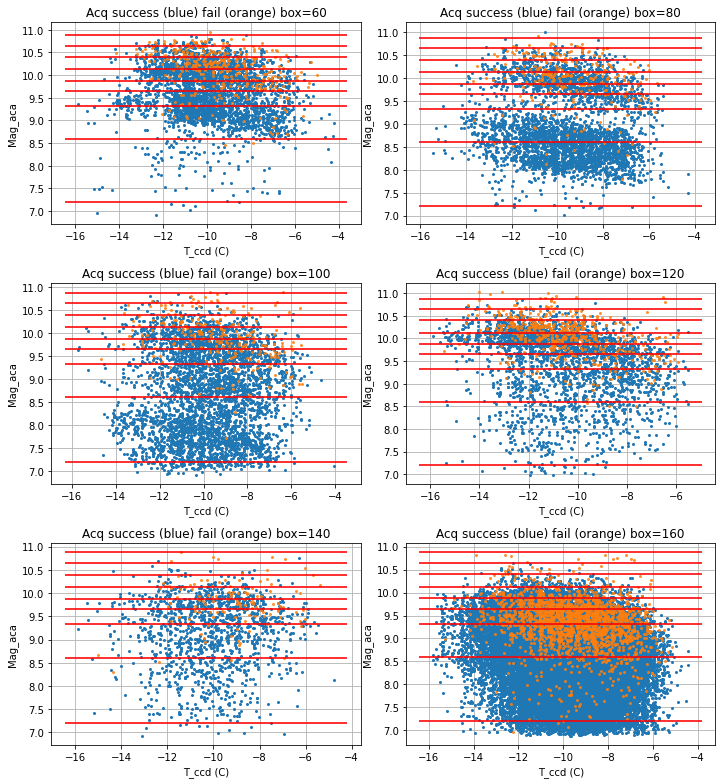

In [26]:
plt.figure(figsize=(10, 11))
for subplot, halfwidth in enumerate([60, 80, 100, 120, 140, 160]):
    plt.subplot(3, 2, subplot + 1)
    ok = ((data_all['halfwidth'] > halfwidth - 10) 
          & (data_all['halfwidth'] <= halfwidth + 10)
          & ~data_all['asvt'])
    plot_fails_mag_aca_vs_t_ccd(mag_bins, data_all[ok])
    plt.title(f'Acq success (blue) fail (orange) box={halfwidth}')
plt.tight_layout()

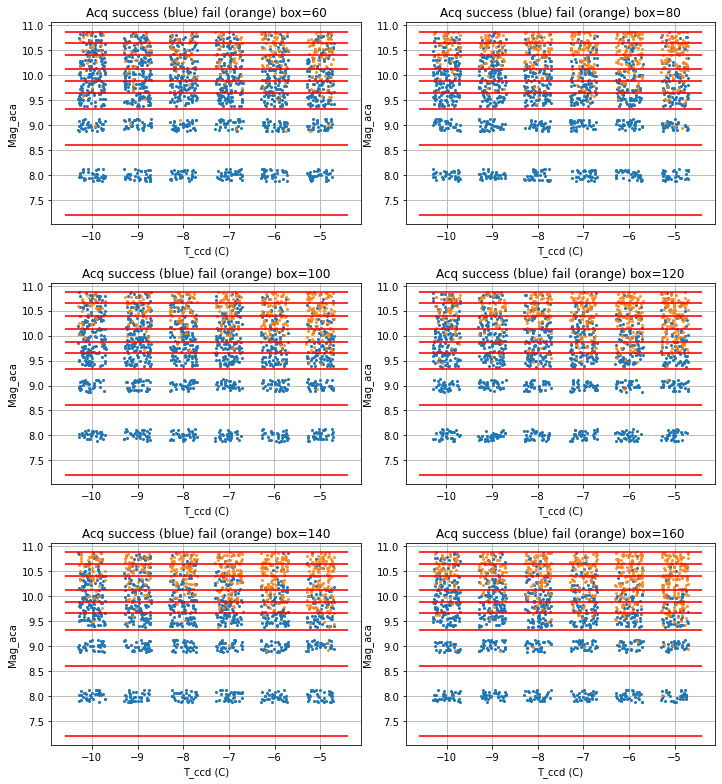

In [27]:
# Plot samples for ASVT
plt.figure(figsize=(10, 11))
for subplot, halfwidth in enumerate([60, 80, 100, 120, 140, 160]):
    plt.subplot(3, 2, subplot + 1)
    ok = ((data_all['halfwidth'] > halfwidth - 10) 
          & (data_all['halfwidth'] <= halfwidth + 10)
          & data_all['asvt'])
    plot_fails_mag_aca_vs_t_ccd(mag_bins, data_all[ok])
    plt.title(f'Acq success (blue) fail (orange) box={halfwidth}')
plt.tight_layout()

## Color != 1.5 fit (this is MOST acq stars)

In [28]:
# fit = fit_sota_model(data_all['color'] == 1.5, ms_disabled=True)
mask_no_1p5 = ((data_all['red_mag_err'] == False) & 
               (data_all['t_ccd'] > -18) &
               (data_all['t_ccd'] < -0.5))

In [29]:
mag0s, mag1s = mag_bins[:-1], mag_bins[1:]
fits = {}
masks = []
for m0, m1 in zip(mag0s, mag1s):
    print(m0, m1)
    mask = mask_no_1p5 & mag_filter(m0, m1) #  & t_ccd_filter(-10.5, 0)

    print(np.count_nonzero(mask))
    masks.append(mask)
    fits[m0, m1] = fit_poly_model(data_all[mask])

7.199999999999999 8.6
23140
failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find ds9 on your PATH'


/var/folders/zn/910d7qgd1ydd4bvww62b6b9r0000gp/T/ipykernel_32608/999339828.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ui.load_arrays(data_id, np.array(data['year']), np.array(data['fail'], dtype=np.float))


Dataset               = 1
Method                = neldermead
Statistic             = binom_stat
Initial fit statistic = 982.62
Final fit statistic   = 955.782 at function evaluation 754
Data points           = 23140
Degrees of freedom    = 23136
Change in statistic   = 26.8378
   model.p0       -2.59892    
   model.p1       0.576745    
   model.p2       -0.528432   
   model.floor    -2.59892    
8.6 9.325
22997
Dataset               = 1
Method                = neldermead
Statistic             = binom_stat
Initial fit statistic = 4093.7
Final fit statistic   = 3436.01 at function evaluation 752
Data points           = 22997
Degrees of freedom    = 22993
Change in statistic   = 657.696
   model.p0       -1.94625    
   model.p1       0.791522    
   model.p2       0.215145    
   model.floor    -2.04017    
9.325 9.65
10490
Dataset               = 1
Method                = neldermead
Statistic             = binom_stat
Initial fit statistic = 4348.04
Final fit statistic   = 2937.75 at 

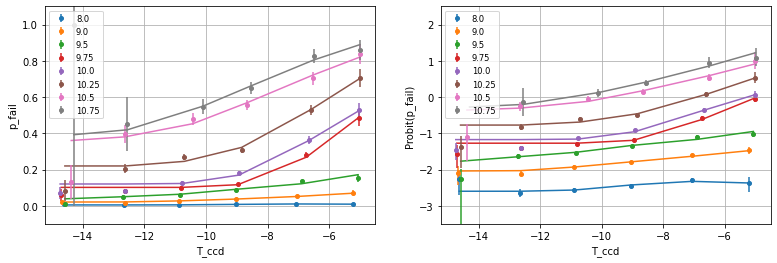

In [30]:
colors = [f'kC{i}' for i in range(9)]

plt.figure(figsize=(13, 4))
for subplot in (1, 2):
    plt.subplot(1, 2, subplot)
    probit = (subplot == 2)
    for m0_m1, color, mask, mag_mean in zip(list(fits), colors, masks, mag_means):
        fit = fits[m0_m1]
        data = data_all[mask]
        data['model'] = p_acq_fail(data)(fit.parvals)        
        plot_fit_grouped(data, 't_ccd', 2.0, 
                         probit=probit, colors=[color, color], label=str(mag_mean))
    plt.grid()
    if probit:
        plt.ylim(-3.5, 2.5)
    else:
        plt.ylim(-0.1, 1.1)
    plt.ylabel('Probit(p_fail)' if probit else 'p_fail')
    plt.xlabel('T_ccd');
    plt.legend(fontsize='small')

**Figure: Validate model fit to data**

*NOTE about figure above:*

In the fit model plot, the model prediction includes the effect of the ad-hoc box_delta correction which is applied to ASVT data. That correction lowers the model prediction for ASVT data, accounting for evidence that ASVT underpredicts acquisition failures in certain mag regimes.

This correction is reflected in the drop for `T_ccd > -11` (most prominent in the grey 10.75 mag curve) which is where ASVT data are included.

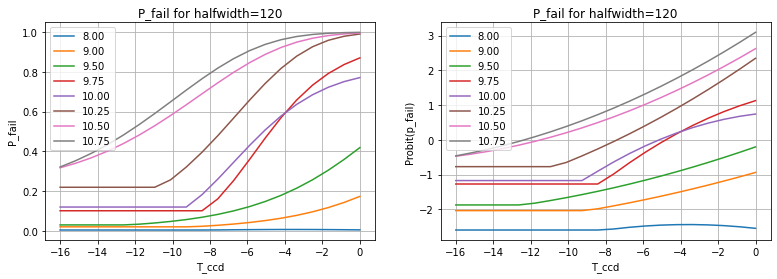

In [31]:
# This computes probabilities for 120 arcsec boxes, corresponding to raw data
t_ccds = np.linspace(-16, -0, 20)
plt.figure(figsize=(13, 4))

for subplot in (1, 2):
    plt.subplot(1, 2, subplot)
    probit = (subplot == 2)
    for m0_m1, color, mag_mean in zip(list(fits), colors, mag_means):
        fit = fits[m0_m1]
        probs = p_fail(fit.parvals, t_ccds)
        if probit:
            probs = stats.norm.ppf(probs)
        plt.plot(t_ccds, probs, label=f'{mag_mean:.2f}')

    plt.legend()
    plt.xlabel('T_ccd')
    plt.ylabel('P_fail' if subplot == 1 else 'Probit(p_fail)')
    plt.title('P_fail for halfwidth=120')
    plt.grid()

**Figure: Probabilities for 120 arcsec boxes, corresponding to raw data**

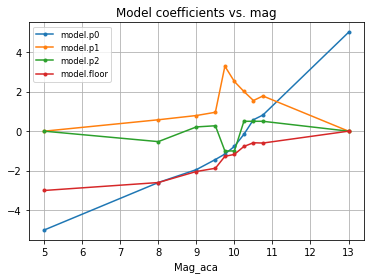

In [32]:
mag_bin_centers = np.concatenate([[5.0], mag_means, [13.0]])
fit_parvals = []
for fit in fits.values():
    fit_parvals.extend(fit.parvals)

fit_parvals = np.array(fit_parvals).reshape(-1, 4)
parvals_mag12 = [[5, 0, 0, 0]]
parvals_mag5 = [[-5, 0, 0, -3]]
fit_parvals = np.concatenate([parvals_mag5, fit_parvals, parvals_mag12])
fit_parvals = fit_parvals.transpose()
for ps, parname in zip(fit_parvals, fit.parnames):
    plt.plot(mag_bin_centers, ps, '.-', label=parname)

plt.legend(fontsize='small')
plt.title('Model coefficients vs. mag')
plt.xlabel('Mag_aca')
plt.grid()

## Define model for color=1.5 stars

- Post AGASC 1.7, there is inadequate data to independently perform the binned
  fitting.
- Instead assume a magnitude error distribution which is informed by examining
  the observed distribution of `dmag = mag_obs - mag_aca` (observed - catalog).  This
  turns out to be well-represented by an `exp(-abs(dmag) / dmag_scale)`
  distribution.  This contrasts with a gaussian that scales as `exp(dmag^2)`.
- Use the assumed mag error distribution and sample the `color != 1.5` star
  probabilities accordingly and compute the weighted mean failure probability.

### Examine distribution of mag error for color=1.5 stars

In [33]:
def plot_mag_errs(acqs, red_mag_err):
    ok = ((acqs['red_mag_err'] == red_mag_err) & 
          (acqs['mag_obs'] > 0) & 
          (acqs['img_func'] == 'star'))
    dok = acqs[ok]
    dmag = dok['mag_obs'] - dok['mag_aca']
    plt.figure(figsize=(14, 4.5))
    plt.subplot(1, 3, 1)
    plt.plot(dok['mag_aca'], dmag, '.')
    plt.plot(dok['mag_aca'], dmag, ',', alpha=0.3)
    plt.xlabel('mag_aca (catalog)')
    plt.ylabel('Mag err')
    plt.title('Mag err (observed - catalog) vs mag_aca')
    plt.xlim(5, 11.5)
    plt.ylim(-4, 2)
    plt.grid()
    
    plt.subplot(1, 3, 2)
    plt.hist(dmag, bins=np.arange(-3, 4, 0.2), log=True);
    plt.grid()
    plt.xlabel('Mag err')
    plt.title('Mag err (observed - catalog)')
    plt.xlim(-4, 2)
    
    plt.subplot(1, 3, 3)
    plt.hist(dmag, bins=100, cumulative=-1, density=True)
    plt.xlim(-1, 1)
    plt.xlabel('Mag err')
    plt.title('Mag err (observed - catalog)')
    plt.grid()

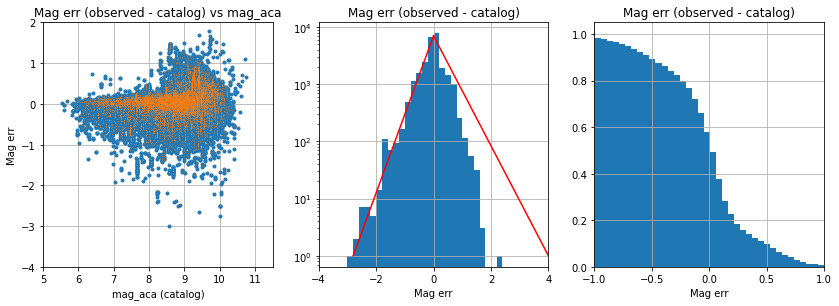

In [34]:
plot_mag_errs(acqs, red_mag_err=True)
plt.subplot(1, 3, 2)
plt.plot([-2.8, 0], [1, 7000], 'r');
plt.plot([0, 4.0], [7000, 1], 'r');
plt.xlim(-4, 4);

### Define an analytical approximation for distribution with ad-hoc positive tail

In [35]:
# Define parameters / metadata for floor model
FLOOR = {'fit_parvals': fit_parvals,
         'mag_bin_centers': mag_bin_centers}

In [36]:
def calc_1p5_mag_err_weights():
    x = np.linspace(-2.8, 4, 18)
    ly = 3.8 * (1 - np.abs(x) / np.where(x > 0, 4.0, 2.8))
    y = 10 ** ly
    return x, y / y.sum()    

In [37]:
FLOOR['mag_errs_1p5'], FLOOR['mag_err_weights_1p5'] = calc_1p5_mag_err_weights()

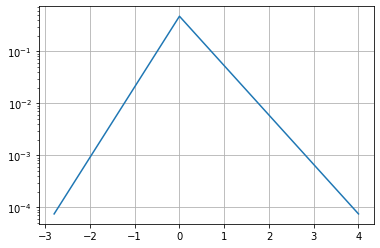

In [38]:
plt.semilogy(FLOOR['mag_errs_1p5'], FLOOR['mag_err_weights_1p5'])
plt.grid()

## Global model for arbitrary mag, t_ccd, color, and halfwidth

In [39]:
def floor_model_acq_prob(mag, t_ccd, color=0.6, halfwidth=120, probit=False):
    """
    Acquisition probability model

    :param mag: Star magnitude(s)
    :param t_ccd: CCD temperature(s)
    :param color: Star color (compared to 1.5 to decide which p_fail model to use)
    :param halfwidth: Search box size (arcsec)
    :param probit: Return probit of failure probability
    
    :returns: acquisition failure probability
    """

    parvals = FLOOR['fit_parvals']
    mag_bin_centers = FLOOR['mag_bin_centers']
    mag_errs_1p5 = FLOOR['mag_errs_1p5']
    mag_err_weights_1p5 = FLOOR['mag_err_weights_1p5']

    # Make sure inputs have right dimensions
    is_scalar, t_ccds, mags, halfwidths, colors = broadcast_arrays(t_ccd, mag, halfwidth, color)
    box_deltas = get_box_delta(halfwidths) 

    p_fails = []
    for t_ccd, mag, box_delta, color in zip(t_ccds.flat, mags.flat, box_deltas.flat, colors.flat):
        if np.isclose(color, 1.5):
            pars_list = [[np.interp(mag + mag_err_1p5, mag_bin_centers, ps) for ps in parvals]
                         for mag_err_1p5 in mag_errs_1p5]
            weights = mag_err_weights_1p5
            if probit:
                raise ValueError('cannot use probit=True with color=1.5 stars')
        else:
            pars_list = [[np.interp(mag, mag_bin_centers, ps) for ps in parvals]]
            weights = [1]

        pf = sum(weight * p_fail(pars, t_ccd, box_delta=box_delta, probit=probit)
                 for pars, weight in zip(pars_list, weights))
        p_fails.append(pf)
    
    out = np.array(p_fails).reshape(t_ccds.shape)
    if is_scalar:
        out = out.item()
    return out

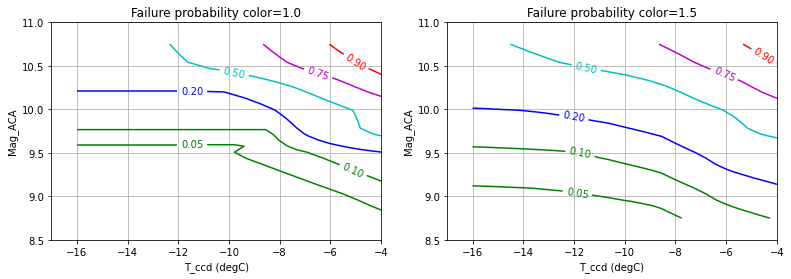

In [40]:
mags, t_ccds = np.mgrid[8.75:10.75:30j, -16:-4:30j]
plt.figure(figsize=(13, 4))
for subplot, color in enumerate([1.0, 1.5]):
    plt.subplot(1, 2, subplot + 1)
    p_fails = floor_model_acq_prob(mags, t_ccds, probit=False, color=color)

    cs = plt.contour(t_ccds, mags, p_fails, levels=[0.05, 0.1, 0.2, 0.5, 0.75, 0.9], 
                     colors=['g', 'g', 'b', 'c', 'm', 'r'])
    plt.clabel(cs, inline=1, fontsize=10)
    plt.grid()
    plt.xlim(-17, -4)
    plt.ylim(8.5, 11.0)
    plt.xlabel('T_ccd (degC)')
    plt.ylabel('Mag_ACA')
    plt.title(f'Failure probability color={color}');

(8.0, 11.0)

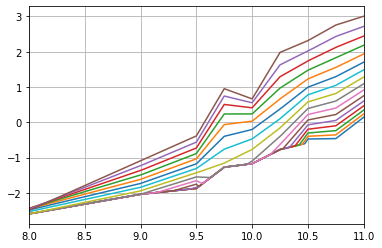

In [41]:
mags = np.linspace(8, 11, 301)
plt.figure()
for t_ccd in np.arange(-16, -0.9, 1):
    p_fails = floor_model_acq_prob(mags, t_ccd, probit=True)
    plt.plot(mags, p_fails)
plt.grid()
plt.xlim(8, 11)

## Compare to flight data for halfwidth=120

Selecting only data with `halfwidth=120` is a clean, model-independent way to
compare the model to raw flight statistics.

### Setup functions to get appropriate data

In [42]:
# NOTE this is in chandra_aca.star_probs as of version 4.27

from scipy.stats import binom

def binom_ppf(k, n, conf, n_sample=1000):
    """
    Compute percent point function (inverse of CDF) for binomial, where
    the percentage is with respect to the "p" (binomial probability) parameter
    not the "k" parameter.
    
    The following example returns the 1-sigma (0.17 - 0.84) confidence interval
    on the true binomial probability for an experiment with 4 successes in 5 trials.
    
    Example::
    
      >>> binom_ppf(4, 5, [0.17, 0.84])
      array([ 0.55463945,  0.87748177])
      
    :param k: int, number of successes (0 < k <= n)
    :param n: int, number of trials
    :param conf: float, array of floats, percent point values
    :param n_sample: number of PMF samples for interpolation
    
    :return: percent point function values corresponding to ``conf``
    """
    ps = np.linspace(0, 1, n_sample)
    vals = binom.pmf(k=k, n=n, p=ps)
    return np.interp(conf, xp=np.cumsum(vals) / np.sum(vals), fp=ps)

In [43]:
binom_ppf(4, 5, [0.17, 0.84])

array([0.55463945, 0.87748177])

In [44]:
n = 156
k = 127
binom_ppf(k, n, [0.17, 0.84])

array([0.78004095, 0.84058371])

In [45]:
def calc_binned_pfail(data_all, mag, dmag, t_ccd, dt, halfwidth=120):
    da = data_all[~data_all['asvt']]
    fail = da['fail'].astype(bool)
    ok = ((np.abs(da['mag_aca'] - mag) < dmag) 
          & (np.abs(da['t_ccd'] - t_ccd) < dt)
          & (da['halfwidth'] == halfwidth)
          )
    n_fail = np.count_nonzero(fail[ok])
    n_acq = np.count_nonzero(ok)
    if n_acq < 5:
        return None
    p_fail = n_fail / n_acq
    p_fail_lower, p_fail_upper = binom_ppf(n_fail, n_acq, [0.17, 0.84])
    mean_t_ccd = np.mean(da['t_ccd'][ok])
    mean_mag = np.mean(da['mag_aca'][ok])
    return p_fail, p_fail_lower, p_fail_upper, mean_t_ccd, mean_mag, n_fail, n_acq

In [46]:
def get_binned_pfails(data, halfwidth=120, year_min=None, print_vals=True):
    pfs_list = []
    if year_min is not None:
        data = data[data['year'] > year_min]
    for mag in (10.0, 10.25, 10.5):
        pfs = []
        for t_ccd in np.arange(-15, -4, 1):
            pf = calc_binned_pfail(data, mag, 0.25, t_ccd, 0.5, halfwidth=halfwidth)
            if pf is not None:
                pfs.append(pf)
                if print_vals:
                    print(f'mag={mag} mean_mag_aca={pf[4]:.2f} '
                          f't_ccd={pf[3]:.2f} p_fail={pf[-2]}/{pf[-1]}={pf[0]:.2f}')
        pfs_list.append(pfs)
    return pfs_list

### Compare model to flight for color != 1.5 stars

In [47]:
def plot_floor_and_flight(color, pfs_list=None, halfwidth=160):

    # This computes probabilities for 160 arcsec boxes, corresponding to raw data
    t_ccds = np.linspace(-16, -4, 20)
    mag_acas = np.array([9.5, 10.0, 10.25, 10.5, 10.75])

    for ii, mag_aca in enumerate(reversed(mag_acas)):
        flight_probs = 1 - acq_success_prob(date='2021-02-01T00:00:00', 
                                            t_ccd=t_ccds, mag=mag_aca, color=color, halfwidth=halfwidth)
        new_probs = floor_model_acq_prob(mag_aca, t_ccds, color=color, halfwidth=halfwidth)
        plt.plot(t_ccds, flight_probs, '--', color=f'C{ii}')
        plt.plot(t_ccds, new_probs, '-', color=f'C{ii}', label=f'mag_aca={mag_aca}')

    if color != 1.5:
        # pf1, pf2 have p_fail, p_fail_lower, p_fail_upper, mean_t_ccd, mean_mag_aca, n_fail, n_acq
        for pfs, clr in zip(pfs_list, ('C3', 'C2', 'C1')):
            for pf in pfs:
                yerr = np.array([pf[0] - pf[1], pf[2] - pf[0]]).reshape(2, 1)
                plt.errorbar(pf[3], pf[0], xerr=0.5, yerr=yerr, color=clr, marker='o')

    # plt.xlim(-16, None)
    plt.legend()
    plt.ylim(0, None)
    plt.xlabel('T_ccd')
    plt.ylabel('P_fail')
    plt.title(f'P_fail (color={color}: new (solid) and flight (dashed)')
    plt.title(f'P_fail flight model (curves) vs. flight data (crosses)')
    plt.grid()

In [48]:
pfails_list = get_binned_pfails(data_all, halfwidth=160)

mag=10.0 mean_mag_aca=9.85 t_ccd=-14.88 p_fail=2/14=0.14
mag=10.0 mean_mag_aca=9.89 t_ccd=-13.97 p_fail=2/41=0.05
mag=10.0 mean_mag_aca=9.88 t_ccd=-12.81 p_fail=32/263=0.12
mag=10.0 mean_mag_aca=9.88 t_ccd=-11.88 p_fail=36/353=0.10
mag=10.0 mean_mag_aca=9.88 t_ccd=-11.02 p_fail=68/418=0.16
mag=10.0 mean_mag_aca=9.88 t_ccd=-10.02 p_fail=68/495=0.14
mag=10.0 mean_mag_aca=9.89 t_ccd=-8.99 p_fail=42/237=0.18
mag=10.0 mean_mag_aca=9.90 t_ccd=-8.12 p_fail=30/154=0.19
mag=10.0 mean_mag_aca=9.89 t_ccd=-7.03 p_fail=17/42=0.40
mag=10.25 mean_mag_aca=10.13 t_ccd=-13.94 p_fail=0/6=0.00
mag=10.25 mean_mag_aca=10.20 t_ccd=-12.83 p_fail=14/35=0.40
mag=10.25 mean_mag_aca=10.19 t_ccd=-11.87 p_fail=8/68=0.12
mag=10.25 mean_mag_aca=10.13 t_ccd=-11.07 p_fail=19/70=0.27
mag=10.25 mean_mag_aca=10.14 t_ccd=-10.00 p_fail=21/82=0.26
mag=10.25 mean_mag_aca=10.13 t_ccd=-9.01 p_fail=9/46=0.20
mag=10.25 mean_mag_aca=10.14 t_ccd=-8.17 p_fail=8/29=0.28
mag=10.25 mean_mag_aca=10.14 t_ccd=-6.92 p_fail=6/13=0.46
mag=10

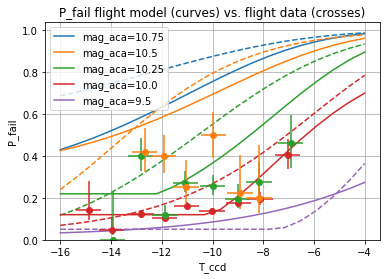

In [49]:
plot_floor_and_flight(color=1.0, pfs_list=pfails_list, halfwidth=160)

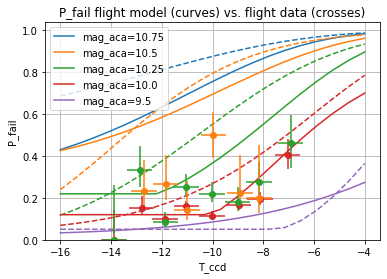

In [50]:
# Plot since 2019.5 when MAXMAG clipping was implemented in flight
pfails_list_maxmag = get_binned_pfails(data_all, halfwidth=160, year_min=2019.5, print_vals=False)
plot_floor_and_flight(color=1.0, pfs_list=pfails_list_maxmag, halfwidth=160)

mag=10.0 mean_mag_aca=10.02 t_ccd=-12.77 p_fail=0/44=0.00
mag=10.0 mean_mag_aca=10.03 t_ccd=-11.96 p_fail=5/108=0.05
mag=10.0 mean_mag_aca=10.03 t_ccd=-10.96 p_fail=6/88=0.07
mag=10.0 mean_mag_aca=10.04 t_ccd=-9.96 p_fail=20/207=0.10
mag=10.0 mean_mag_aca=10.02 t_ccd=-8.97 p_fail=22/146=0.15
mag=10.0 mean_mag_aca=9.98 t_ccd=-8.10 p_fail=23/155=0.15
mag=10.0 mean_mag_aca=9.96 t_ccd=-7.04 p_fail=23/77=0.30
mag=10.0 mean_mag_aca=9.93 t_ccd=-6.18 p_fail=5/20=0.25
mag=10.25 mean_mag_aca=10.14 t_ccd=-12.81 p_fail=0/40=0.00
mag=10.25 mean_mag_aca=10.17 t_ccd=-11.92 p_fail=5/109=0.05
mag=10.25 mean_mag_aca=10.21 t_ccd=-11.00 p_fail=13/89=0.15
mag=10.25 mean_mag_aca=10.20 t_ccd=-9.96 p_fail=34/223=0.15
mag=10.25 mean_mag_aca=10.21 t_ccd=-8.98 p_fail=26/131=0.20
mag=10.25 mean_mag_aca=10.21 t_ccd=-8.11 p_fail=25/105=0.24
mag=10.25 mean_mag_aca=10.22 t_ccd=-7.02 p_fail=15/37=0.41
mag=10.25 mean_mag_aca=10.15 t_ccd=-6.23 p_fail=2/7=0.29
mag=10.5 mean_mag_aca=10.40 t_ccd=-12.75 p_fail=1/16=0.06
mag

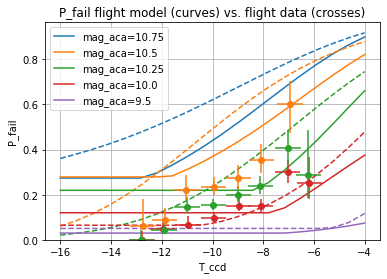

In [67]:
# Plot since 2019.5 when MAXMAG clipping was implemented in flight
pfails_list_maxmag = get_binned_pfails(data_all, halfwidth=60, year_min=2019.5, print_vals=True)
plot_floor_and_flight(color=1.0, pfs_list=pfails_list_maxmag, halfwidth=60)

### Compare model to flight for color = 1.5 stars

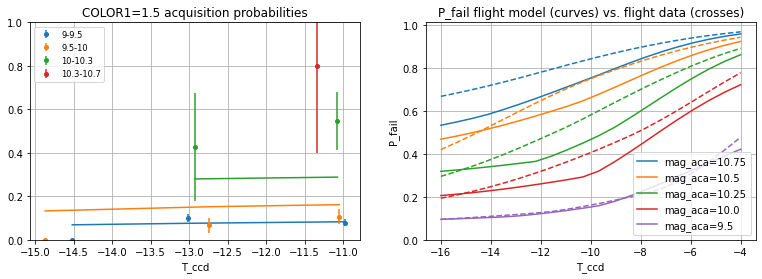

In [52]:
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
for m0, m1, color in [(9, 9.5, 'C0'), (9.5, 10, 'C1'), (10, 10.3, 'C2'), (10.3, 10.7, 'C3')]:
    ok = data_all['red_mag_err'] & mag_filter(m0, m1) & t_ccd_filter(-16, -10)
    data = data_all[ok]
    data['model'] = floor_model_acq_prob(data['mag_aca'], data['t_ccd'], color=1.5, halfwidth=data['halfwidth'])
    plot_fit_grouped(data, 't_ccd', 2.0, 
                     probit=False, colors=[color, color], label=f'{m0}-{m1}')
plt.ylim(0, 1.0)
plt.legend(fontsize='small')
plt.grid()
plt.xlabel('T_ccd')
plt.title('COLOR1=1.5 acquisition probabilities')

plt.subplot(1, 2, 2)
plot_floor_and_flight(color=1.5)

## Write model as a 3-d grid to a gzipped FITS file

In [53]:
def write_model_as_fits(model_name,
                        comment=None,
                        mag0=5, mag1=12, n_mag=141,  # 0.05 mag spacing
                        t_ccd0=-16, t_ccd1=-1, n_t_ccd=31,  # 0.5 degC spacing
                        halfw0=60, halfw1=180, n_halfw=7,  # 20 arcsec spacing
                        ):
    from astropy.io import fits
    
    mags = np.linspace(mag0, mag1, n_mag)
    t_ccds = np.linspace(t_ccd0, t_ccd1, n_t_ccd)
    halfws = np.linspace(halfw0, halfw1, n_halfw)
    mag, t_ccd, halfw = np.meshgrid(mags, t_ccds, halfws, indexing='ij')

    print('Computing probs, stand by...')
    
    # COLOR = 1.5 (stars with poor mag estimates)
    p_fails = floor_model_acq_prob(mag, t_ccd, halfwidth=halfw, probit=False, color=1.5)
    p_fails_probit_1p5 = stats.norm.ppf(p_fails)

    # COLOR not 1.5 (most stars)
    p_fails_probit = floor_model_acq_prob(mag, t_ccd, halfwidth=halfw, probit=True, color=1.0)
    
    hdu = fits.PrimaryHDU()
    if comment:
        hdu.header['comment'] = comment
    hdu.header['date'] = DateTime().fits
    hdu.header['mdl_name'] = model_name
    hdu.header['mag_lo'] = mags[0]
    hdu.header['mag_hi'] = mags[-1]
    hdu.header['mag_n'] = len(mags)
    hdu.header['t_ccd_lo'] = t_ccds[0]
    hdu.header['t_ccd_hi'] = t_ccds[-1]
    hdu.header['t_ccd_n'] = len(t_ccds)
    hdu.header['halfw_lo'] = halfws[0]
    hdu.header['halfw_hi'] = halfws[-1]
    hdu.header['halfw_n'] = len(halfws)

    hdu1 = fits.ImageHDU(p_fails_probit.astype(np.float32))
    hdu1.header['comment'] = 'COLOR1 != 1.5 (good mag estimates)'
    
    hdu2 = fits.ImageHDU(p_fails_probit_1p5.astype(np.float32))
    hdu2.header['comment'] = 'COLOR1 == 1.5 (poor mag estimates)'

    hdus = fits.HDUList([hdu, hdu1, hdu2])
    print(f'Writing {model_name}.fits.gz...')
    hdus.writeto(f'{model_name}.fits.gz', overwrite=True)

In [54]:
comment = f'Created with fit_acq_model-{MODEL_DATE}-binned-poly-binom-floor.ipynb in aca_stats repository'
write_model_as_fits(MODEL_NAME, comment=comment)

Computing probs, stand by...
Writing grid-floor-2022-11.fits.gz...


In [55]:
# Fudge the chandra_aca.star_probs global STAR_PROBS_DATA_DIR temporarily
# in order to load the dev model that was just created locally
_dir_orig = star_probs.STAR_PROBS_DATA_DIR
star_probs.STAR_PROBS_DATA_DIR = '.'
grid_model_acq_prob(model=MODEL_NAME)
star_probs.STAR_PROBS_DATA_DIR = _dir_orig

/Users/aldcroft/miniconda3/envs/ska3/lib/python3.8/site-packages/chandra_aca/star_probs.py:288: UserWarning: 
Model grid-floor-2022-11 computed between halfw <= 60.0 <= 180.0, clipping input halfw(s) outside that range.
  warnings.warn('\nModel {} computed between {} <= {} <= {}, '
/Users/aldcroft/miniconda3/envs/ska3/lib/python3.8/site-packages/chandra_aca/star_probs.py:288: UserWarning: 
Model grid-floor-2022-11 computed between halfw <= 60.0 <= 180.0, clipping input halfw(s) outside that range.
  warnings.warn('\nModel {} computed between {} <= {} <= {}, '
/Users/aldcroft/miniconda3/envs/ska3/lib/python3.8/site-packages/chandra_aca/star_probs.py:288: UserWarning: 
Model grid-floor-2022-11 computed between halfw <= 60.0 <= 180.0, clipping input halfw(s) outside that range.
  warnings.warn('\nModel {} computed between {} <= {} <= {}, '
/Users/aldcroft/miniconda3/envs/ska3/lib/python3.8/site-packages/chandra_aca/star_probs.py:288: UserWarning: 
Model grid-floor-2022-11 computed between

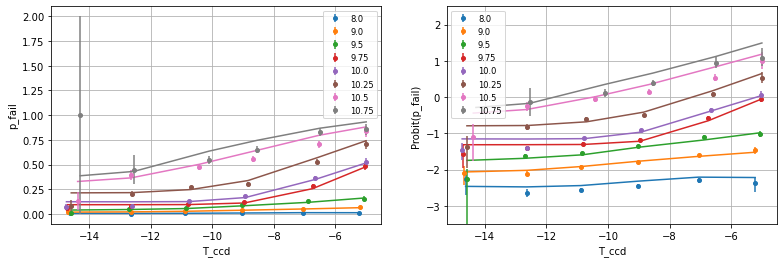

In [56]:
# Remake standard plot comparing grouped data to model, but now use
# chandra_aca.star_probs grid_model_acq_prob function with the newly
# generated 3-d FITS model that we just loaded.

colors = [f'kC{i}' for i in range(9)]

plt.figure(figsize=(13, 4))
for subplot in (1, 2):
    plt.subplot(1, 2, subplot)
    probit = (subplot == 2)
    for m0_m1, color, mask, mag_mean in zip(list(fits), colors, masks, mag_means):
        fit = fits[m0_m1]
        data = data_all[mask]
        data['model'] = 1 - grid_model_acq_prob(data['mag_aca'], data['t_ccd'],
                                                halfwidth=data['halfwidth'],
                                                model=MODEL_NAME)
        plot_fit_grouped(data, 't_ccd', 2.0, 
                         probit=probit, colors=[color, color], label=str(mag_mean))
    plt.grid()
    if probit:
        plt.ylim(-3.5, 2.5)
    plt.ylabel('Probit(p_fail)' if probit else 'p_fail')
    plt.xlabel('T_ccd');
    plt.legend(fontsize='small')

**NOTE in figure above** 

There is a subtle but important difference from the fit model to data comparison plot which occurs just after the model fitting.  In the fit model plot, the model prediction includes the effect of the ad-hoc `box_delta` correction which is applied to ASVT data.  That correction lowers the model prediction for ASVT data, accounting for evidence that ASVT underpredicts acquisition failures in certain mag regimes.

In the plot above that `box_delta` correction is NOT applied so that the model prediction is higher.  In particular there is an obvious gap between the binned data at faint mags and the model, but this is a reflection of the fact that the binned data at faint mags are dominated by ASVT samples and ASVT is purposely penalized.

tl;dr - the model is somewhat *conservative* relative to flight and ASVT.

In [57]:
# Check chandra_aca implementation vs. native model from this notebook
mags = np.linspace(5, 12, 40)
t_ccds = np.linspace(-16, -1, 40)
halfws = np.linspace(60, 180, 7)
mag, t_ccd, halfw = np.meshgrid(mags, t_ccds, halfws, indexing='ij')

# First color != 1.5
#  Notebook
nb_probs = floor_model_acq_prob(mag, t_ccd, halfwidth=halfw, probit=True, color=1.0)
#  Chandra_aca.  Note that grid_model returns p_success, so need to negate it.
#  Remember this is in probit space, not linear, so that is why negation is correct.
ca_probs = -grid_model_acq_prob(mag, t_ccd, halfwidth=halfw, probit=True, color=1.0, 
                                model=MODEL_NAME)

assert nb_probs.shape == ca_probs.shape
print('Max difference in probit is {:.3f}'.format(np.max(np.abs(nb_probs - ca_probs))))
assert np.allclose(nb_probs, ca_probs, rtol=0, atol=0.1)


Max difference in probit is 0.038


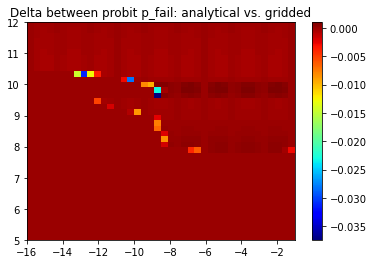

In [58]:
d_probs = (nb_probs - ca_probs)[:, :, 3]
plt.imshow(d_probs, origin='lower', extent=[-16, -1, 5, 12], aspect='auto', cmap='jet')
plt.colorbar();
plt.title('Delta between probit p_fail: analytical vs. gridded');

(8.0, 11.0)

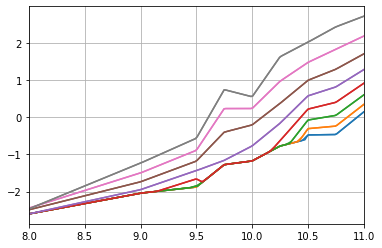

In [59]:
mags = np.linspace(8, 11, 200)
plt.figure()
for ii, t_ccd in enumerate(np.arange(-16, -0.9, 2)):
    p_fails = floor_model_acq_prob(mags, t_ccd, probit=True)
    plt.plot(mags, p_fails, color=f'C{ii}')
    p_success = grid_model_acq_prob(mags, t_ccd, probit=True, model=MODEL_NAME)
    plt.plot(mags, -p_success, color=f'C{ii}')
plt.grid()
plt.xlim(8, 11)

## Generate regression data for chandra_aca

The real testing is done here with a copy of the functions from `chandra_aca`, but
now generate some regression test data as a smoke test that things are working
on all platforms.

In [60]:
mags = [9, 9.5, 10.5]
t_ccds = [-10, -5]
halfws = [60, 120, 160]
mag, t_ccd, halfw = np.meshgrid(mags, t_ccds, halfws, indexing='ij')

probs = floor_model_acq_prob(mag, t_ccd, halfwidth=halfw, probit=True, color=1.0)
print(repr(probs.round(3).flatten()))

probs = floor_model_acq_prob(mag, t_ccd, halfwidth=halfw, probit=False, color=1.5)
probs = stats.norm.ppf(probs)
print(repr(probs.round(3).flatten()))

array([-2.04 , -2.04 , -1.844, -2.04 , -1.619, -1.333, -1.876, -1.656,
       -1.37 , -1.592, -1.037, -0.75 , -0.335,  0.22 ,  0.507,  0.673,
        1.228,  1.515])
array([-1.686, -1.614, -1.468, -1.402, -1.08 , -0.884, -1.32 , -1.176,
       -1.024, -0.891, -0.526, -0.325, -0.163,  0.22 ,  0.419,  0.611,
        1.037,  1.25 ])


In [61]:
# Put this MD5 sum into the regression tests as well
import hashlib
hashlib.md5(open(f'{MODEL_NAME}.fits.gz', 'rb').read()).hexdigest()

'4e411816d43586faf53a1465eaef1b35'

### Some statistics about interval

In [62]:
aok = acqs[acq_ok]

In [63]:
aok.colnames

['tstart',
 'obsid',
 'obc_id',
 'halfwidth',
 'warm_pix',
 'mag_aca',
 'mag_obs',
 'known_bad',
 'color',
 'img_func',
 'ion_rad',
 'sat_pix',
 'agasc_id',
 't_ccd',
 'slot',
 'year',
 'quarter',
 'fail',
 'red_mag_err',
 'mag_aca_err',
 'asvt']

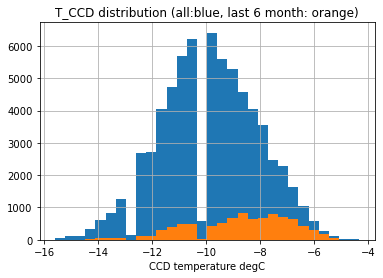

In [64]:
vals, bins, patches = plt.hist(aok['t_ccd'], bins=30)
ok = np.max(aok['year']) - aok['year'] < 0.5  # last 6 months
plt.hist(aok['t_ccd'][ok], bins=bins, facecolor='C1');
plt.title('T_CCD distribution (all:blue, last 6 month: orange)');
plt.xlabel('CCD temperature degC')
plt.grid();

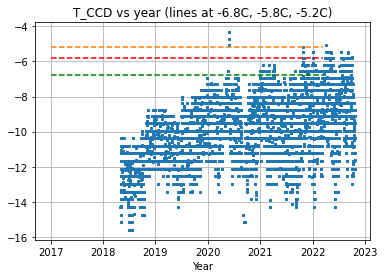

In [65]:
# Previous penalty / planning limits: -7.5 C, -6.5 C
# Current penalty / planning limits: -6.8 C, -5.8 C
# Proposed penalty / planning limits: -6.2 C, -5.2 C

plt.plot(aok['year'], aok['t_ccd'], '.', ms=3)
plt.xlabel('Year')
plt.hlines([-6.8, -5.8, -5.2], 2017, 2022.2, ls='--', color=['g', 'r', 'C1'])
plt.grid();
plt.title('T_CCD vs year (lines at -6.8C, -5.8C, -5.2C)');

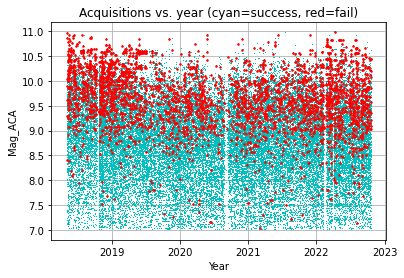

In [66]:
plt.plot(aok['year'], aok['mag_aca'], ',', color='c')
ok = aok['fail'].astype(bool)
plt.plot(aok['year'][ok], aok['mag_aca'][ok], '.', color='r', ms=3);
plt.xlabel('Year')
plt.grid();
plt.ylabel('Mag_ACA')
plt.title('Acquisitions vs. year (cyan=success, red=fail)');